In [1]:
import numpy as np

from asteroloc8.prior import NuPrior

In [2]:
tic261154649 = NuPrior(
    teff_spec=4947., teff_spec_err=92.,
    logg_spec=2.4565, logg_spec_err=0.05, 
    plx=1.44, plx_err=0.01, 
    jmag=8.293, jmag_err=0.03, 
    hmag=7.694, hmag_err=0.023, 
    kmag=7.559, kmag_err=0.027,
)

In [3]:
a=tic261154649.gaiascalnmx(mass='giants')
print('numax_50th = ', a[0][0])
print('numax_std = ', a[0][1])

numax_50th =  30.380043075300243
numax_std =  2.148034158394226


(array([  4.,  19.,  71., 162., 214., 240., 185.,  73.,  26.,   6.]),
 array([23.4107659 , 24.78007002, 26.14937415, 27.51867827, 28.8879824 ,
        30.25728652, 31.62659065, 32.99589477, 34.3651989 , 35.73450302,
        37.10380715]),
 <BarContainer object of 10 artists>)

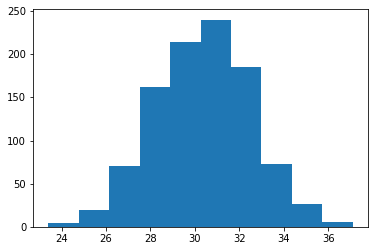

In [4]:
from matplotlib import pyplot as plt

plt.hist(a[1])

In [5]:
print(tic261154649.specnmx())

((34.71131291448406, 4.178559330045199), array([34.26264805, 34.04296372, 35.18725298, 40.94604453, 39.00919806,
       34.50720624, 35.84935628, 33.05698562, 34.60548068, 36.87153365,
       30.85061799, 31.18483137, 37.65647708, 36.65924181, 34.43181795,
       36.95073134, 34.8269298 , 33.60923275, 31.11798847, 29.70590632,
       35.994161  , 34.27382649, 28.36589258, 33.96861095, 38.85488254,
       35.60776362, 31.65435482, 36.81793196, 42.20589788, 36.88280409,
       35.90439907, 32.80710801, 34.43628972, 35.00210223, 30.99211146,
       30.86506548, 33.28864793, 34.03341642, 32.13426889, 31.55863489,
       33.06927023, 39.63900344, 29.71856391, 48.50702766, 35.84043895,
       39.23702244, 33.92449792, 35.17852701, 35.6706563 , 34.38722289,
       33.09764111, 32.26248722, 40.15630279, 36.73658758, 34.90976078,
       29.67336496, 30.84913123, 36.54502822, 31.10068598, 31.17218128,
       34.84148137, 42.49218328, 36.74648389, 32.52951824, 33.84966709,
       29.77270013, 33.

In [6]:
infile='DR16_APOTIC_NS_TMshort2.txt'

In [7]:
outfile = infile.replace('.txt','_out.txt')

In [8]:
stars=np.loadtxt(infile, usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14), skiprows=1)

In [9]:
ids,ateff,atefferr,alogg,aloggerr, gparallax, gparallaxerr, tj, tjerr,th, therr,tk, tkerr=zip(*stars) 

In [10]:
open(outfile,'w').write('## TICID  specnumax  specnumaxerr gaianumax  gaianumaxerr \n')

59

In [ ]:
for i in range(len(ids)):
    star=NuPrior(teff_spec=ateff[i], teff_spec_err=atefferr[i], logg_spec=alogg[i], logg_spec_err=aloggerr[i], plx=gparallax[i], plx_err=gparallaxerr[i], 
        jmag=tj[i], jmag_err=tjerr[i], hmag=th[i], hmag_err=therr[i], kmag=tk[i], kmag_err=tkerr[i])
 
    if gparallax[i] > 0:
        gaiastar=star.gaiascalnmx(mass='giants')
        gaianumaxstar=gaiastar[0][0]
        gaianumaxrangestar=gaiastar[0][1]
    else:
        gaianumaxstar=-9999
        gaianumaxrangestar=-9999

    if (ateff[i] > 0 and alogg[i] > -10):
        specstar=star.specnmx()
        specnumaxstar=specstar[0][0]
        specnumaxrangestar=specstar[0][1]
    else:
        specnumaxstar=-9999
        specnumaxrangestar=-9999   
        
    lin='   %.0f'%ids[i]+'\t'+'   %.6f'%specnumaxstar+'\t'+'   %.6f'%specnumaxrangestar+'\t'+'   %.6f'%gaianumaxstar+'\t'+'   %.6f'%gaianumaxrangestar+'\n'
    open(outfile,'a').write(lin)     

/Users/ajl573/Repos/alexlyttle/asteroloc8/asteroloc8/prior.py:170: RuntimeWarning: invalid value encountered in log10
  MK = Kmag-(5*np.log10(1000/parallax)-5)
